# Potato Disease Classification - Using CNN

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [26]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

### Loading data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 2152 files belonging to 3 classes.


#### Classes based on folder names

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
#Total number of files / Batch Size
len(dataset)

68

### Visualize some of the images from our dataset

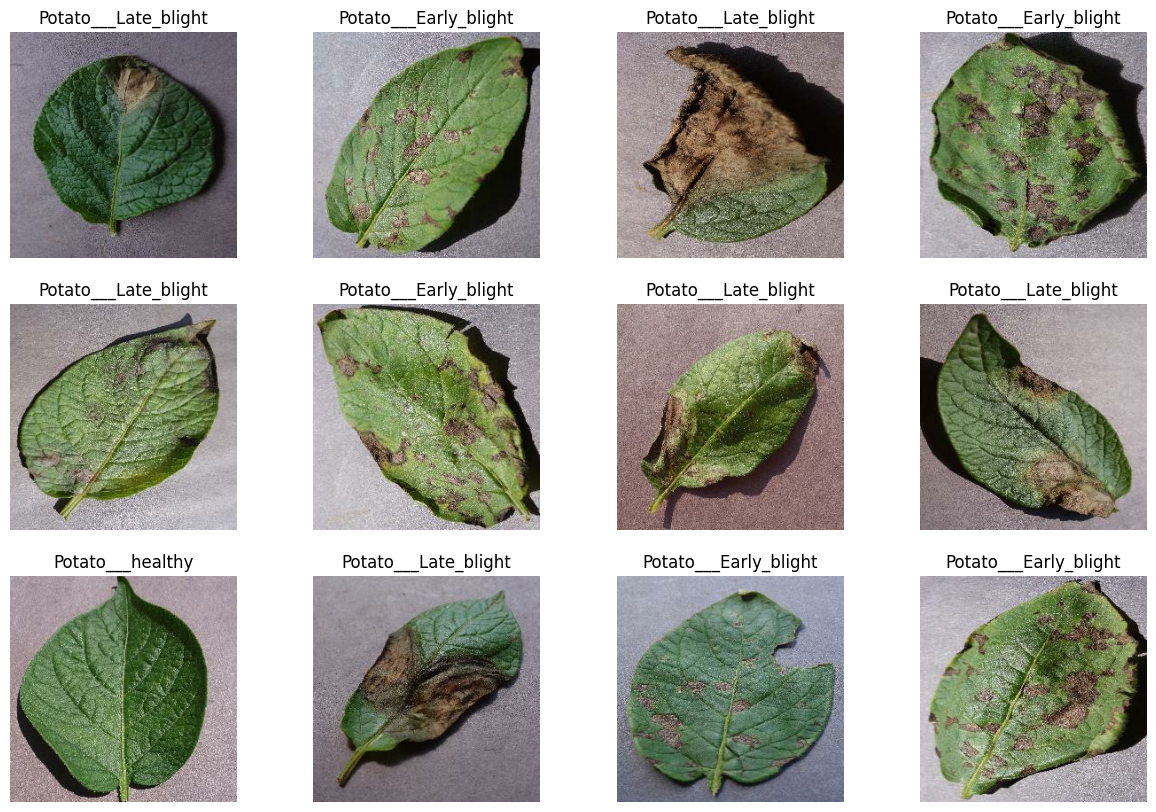

In [10]:
# Display Image Data
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## Train Test Split

In [11]:
#80% Train, 10% Validation & remaining 10% Test
def get_dataset_partitions_tf (ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size= len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
 
    return train_ds,val_ds,test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


#### Cache, Shuffle, and Prefetch the Dataset

In [14]:
#Prefetch & Cache
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model
#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

#### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Applying Data Augmentation to Train Dataset

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [27]:
INPUT_SHAPE = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")    
])

model.build(input_shape=INPUT_SHAPE)

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

#### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [30]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [31]:
history = model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 6s 91ms/step - loss: 0.8840 - accuracy: 0.5081 - val_loss: 0.7386 - val_accuracy: 0.6667
Epoch 2/50
54/54 [==============================] - 5s 89ms/step - loss: 0.6372 - accuracy: 0.7176 - val_loss: 0.4169 - val_accuracy: 0.8542
Epoch 3/50
54/54 [==============================] - 5s 88ms/step - loss: 0.4217 - accuracy: 0.8247 - val_loss: 0.3175 - val_accuracy: 0.9062
Epoch 4/50
54/54 [==============================] - 5s 88ms/step - loss: 0.2614 - accuracy: 0.9103 - val_loss: 0.2094 - val_accuracy: 0.9219
Epoch 5/50
54/54 [==============================] - 5s 89ms/step - loss: 0.1399 - accuracy: 0.9439 - val_loss: 0.2567 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 5s 87ms/step - loss: 0.1762 - accuracy: 0.9369 - val_loss: 0.2433 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 5s 86ms/step - loss: 0.1578 - accuracy: 0.9404 - val_loss: 0.1558 - val_accuracy: 0.9219
Epoch 8/50
54

In [32]:
scores = model.evaluate(test_ds)
scores

1/8 [==>...........................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

8/8 [==============================] - 0s 19ms/step - loss: 0.0511 - accuracy: 0.9922


[0.05106916278600693, 0.9921875]

Scores is just a list containing loss and accuracy value


#### Plotting the Accuracy and Loss Curves

{'verbose': 1, 'epochs': 50, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


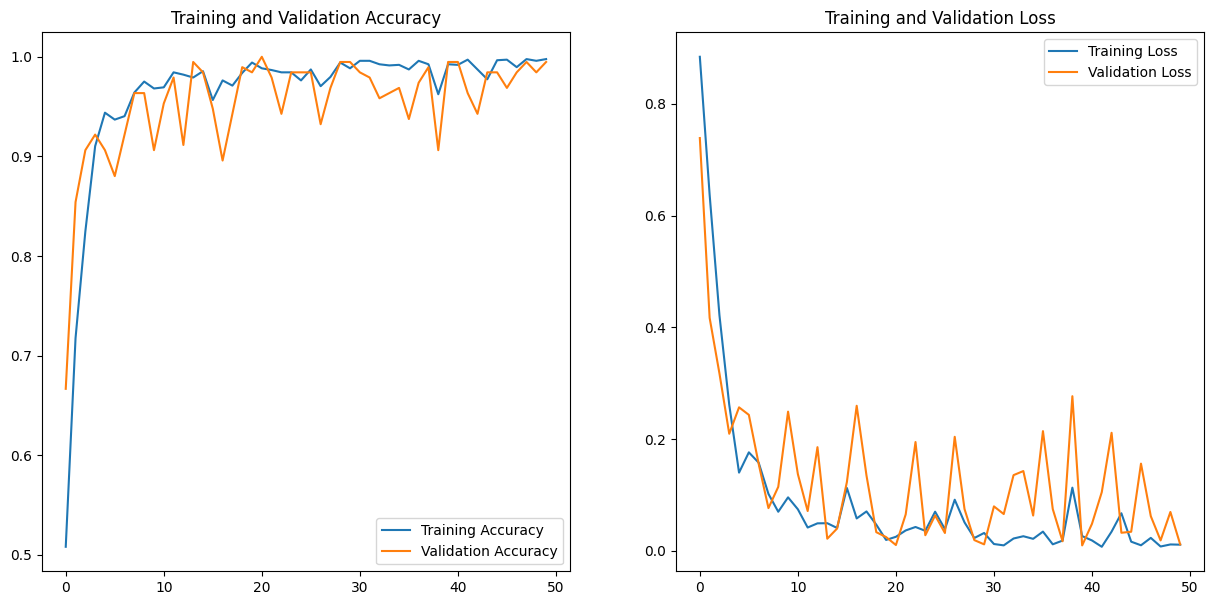

In [33]:
print(history.params)
print(history.history.keys())

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Run prediction on a sample image (Compare Actuals vs Prediction)

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 25ms/step
predicted label: Potato___Late_blight


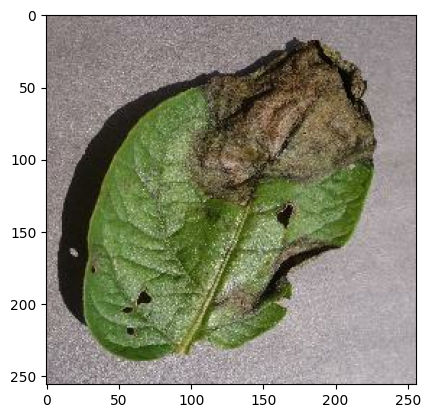

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#### Inferencing on different sample images

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


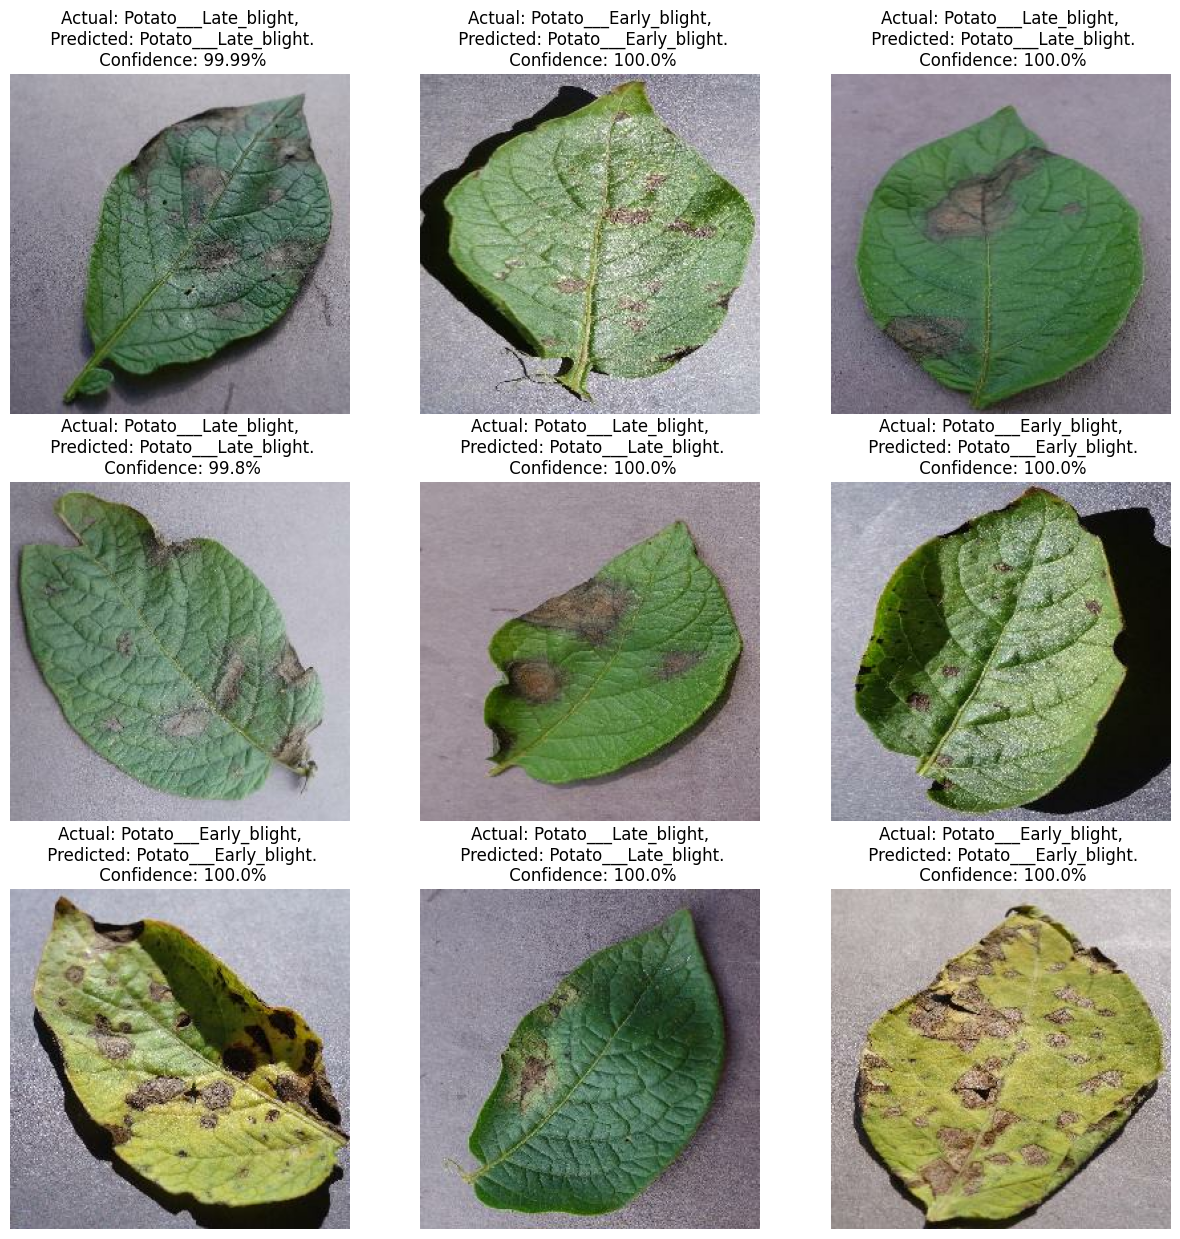

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model
We append the model to the list of models as a new version

In [40]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


In [41]:
model.save("../potato.h5")